In [1]:
import os
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from kaggle.api.kaggle_api_extended import KaggleApi
import os
import re
from pathlib import Path
from typing import List
from langchain_openai import ChatOpenAI
from tavily import TavilyClient

from pydantic import BaseModel, Field

from typing import TypedDict, List, Any, Optional, Dict
from typing import Annotated, Literal
from operator import add

In [3]:
OPEN_API_KEY = os.getenv('OPEN_API_KEY')

LANGSMITH_TRACING = os.getenv('LANGSMITH_TRACING')
LANGSMITH_API_KEY = os.getenv('LANGSMITH_API_KEY')
LANGSMITH_PROJECT = os.getenv('LANGSMITH_PROJECT')
LANGSMITH_ENDPOINT = os.getenv('LANGSMITH_ENDPOINT')

TAVILY_API_KEY = os.getenv('TAVILY_API_KEY')

In [4]:

llm = ChatOpenAI(model="gpt-4o", temperature=0)

In [5]:

# Initialize Tavily client
tavily_client = TavilyClient(api_key=TAVILY_API_KEY)

In [6]:
class TavilySearchOutput(BaseModel):
    title: str
    url: str
    content: str


In [7]:
class FileRecord(BaseModel):
    path: str
    rel_path: str
    ext: str

class DownloadedDataset(BaseModel):
    source_url: str
    source_id: str
    display_name: Optional[str] = None
    dest_dir: str
    files: List[FileRecord]
    meta: Dict[str, Any] = Field(default_factory=dict)


class SourcingAgentState(TypedDict):
    query: str
    tavilySearchOutput: List[TavilySearchOutput]
    status: Annotated[List[str], add]
    download_results: Annotated[List[DownloadedDataset], add]


In [8]:
# This function takes your search term, looks it up on dataset-heavy sites, filters duplicates, and returns a clean list of dataset pages.

def tavily_search_tool(state: SourcingAgentState):
    """Search Kaggle only and return up to 10 most relevant, deduped dataset links."""
    query = state["query"]

    site_queries = {
        "kaggle": f"{query} dataset site:kaggle.com/datasets"
    }

    def which_site(url: str) -> str | None:
        u = url.lower()
        if "kaggle.com/datasets/" in u:
            return "kaggle"
        return None

    def relevance_score(site: str, title: str, url: str, content: str) -> float:
        t = (title or "").lower()
        u = (url or "").lower()
        c = (content or "").lower()
        score = 0.0
        if any(x in u for x in [".csv", ".xlsx", ".json", "/download", "/raw/"]):
            score += 3.0
        if any(x in c for x in ["csv", "xlsx", "json", "download"]):
            score += 2.0
        for tok in set(query.lower().split()):
            if tok and (tok in t or tok in c):
                score += 0.5
        if site == "kaggle":
            score += 0.5
        return score

    candidates: list[tuple[str, TavilySearchOutput, float]] = []
    seen_urls: set[str] = set()

    # Collect per-site, compute scores (Kaggle only)
    for site, q in site_queries.items():
        try:
            r = tavily_client.search(query=q, search_depth="basic", max_results=15)
        except Exception:
            continue
        if not isinstance(r, dict) or "results" not in r:
            continue
        for h in r["results"]:
            url = h.get("url", "") if isinstance(h, dict) else ""
            site_name = which_site(url) if url else None
            if site_name is None:
                continue
            if url in seen_urls:
                continue
            seen_urls.add(url)
            title = h.get("title", "")
            content = h.get("content", "")
            tso = TavilySearchOutput(title=title, url=url, content=content)
            score = relevance_score(site_name, title, url, content)
            candidates.append((site_name, tso, score))

    candidates.sort(key=lambda x: x[2], reverse=True)

    selected: list[TavilySearchOutput] = []
    used_urls: set[str] = set()

    for _, tso, _ in candidates:
        if len(selected) >= 10:
            break
        if tso.url in used_urls:
            continue
        selected.append(tso)
        used_urls.add(tso.url)

    return { "tavilySearchOutput": selected, "status": ["Gathered Kaggle urls"] }

# Get datasest from Kaggle

## Tool to download Kaggle Files: download_kaggle_files

In [9]:
def download_kaggle_files(state: SourcingAgentState, data_dir: str = './data') -> dict:
    """
    Download each Kaggle URL into its own folder and return structured bundles for UI/analysis.
    """

    urls = [tso.url for tso in state['tavilySearchOutput']]

    api = KaggleApi()
    api.authenticate()

    base_dir = Path(data_dir) / 'kaggle'
    base_dir.mkdir(parents=True, exist_ok=True)

    def sanitize_slug(slug: str) -> str:
        # 'owner/name' -> 'owner__name' and strip unsafe chars
        return re.sub(r'[^a-zA-Z0-9._-]+', '_', slug.replace('/', '__'))

    bundles: List[DownloadedDataset] = []

    for url in urls:
        # Extract dataset slug from URL
        m = re.search(r'kaggle\.com/datasets/([^/]+/[^/?#]+)', url)
        if not m:
            continue
        slug = m.group(1)
        owner = slug.split('/')[0]
        name = slug.split('/')[-1]

        dest_dir = base_dir / sanitize_slug(slug)
        dest_dir.mkdir(parents=True, exist_ok=True)

        api.dataset_download_files(
            slug,
            path=str(dest_dir),
            force=False,
            quiet=True,
            unzip=True
        )

        files: List[FileRecord] = []
        for p in dest_dir.rglob('*'):
            if p.is_file():
                try:
                    size = p.stat().st_size
                except Exception:
                    size = 0
                files.append(FileRecord(
                    path=str(p.resolve()),
                    rel_path=str(p.relative_to(dest_dir)),
                    ext=p.suffix.lower(),
                ))

        bundles.append(DownloadedDataset(
            source_url=url,
            source_id=slug,
            display_name=name,
            dest_dir=str(dest_dir.resolve()),
            files=files,
            meta={
                'owner': owner,
                'num_files': len(files),
            }
        ))

    return {"download_results": bundles, "status": ["Downloaded Kaggle bundles"]}


In [10]:
def end_agent(state: SourcingAgentState):
    return state


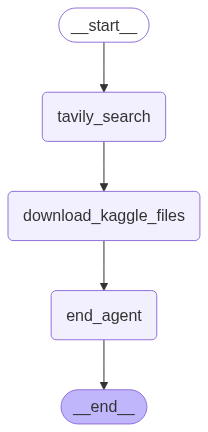

In [11]:
from langgraph.graph import StateGraph, START, END

graph = StateGraph(SourcingAgentState)

graph.add_node("tavily_search", tavily_search_tool)
graph.add_node("download_kaggle_files", download_kaggle_files)
graph.add_node("end_agent", end_agent)

graph.add_edge(START, "tavily_search")
graph.add_edge("tavily_search", "download_kaggle_files")
graph.add_edge("download_kaggle_files", "end_agent")

final_graph = graph.compile()

from IPython.display import Image, display
display(Image(final_graph.get_graph().draw_mermaid_png()))



In [12]:
query = "Spotify recommendation"

state = SourcingAgentState(query=query)


In [13]:
for event in final_graph.stream(state):
    print(event)

{'tavily_search': {'tavilySearchOutput': [TavilySearchOutput(title='Spotify Tracks Dataset - Kaggle', url='https://www.kaggle.com/datasets/maharshipandya/-spotify-tracks-dataset', content='🎹 Spotify Tracks Dataset 🎹 Spotify Tracks Dataset 🎹 Spotify Tracks Dataset - Track by Track Commentary Say Something 70 229400 False 0.407 0.147 Image 7 Song Popularity Prediction - Spotify more_vert Updated 2 years ago 🎹 Spotify Tracks Dataset Image 11 Spotify Dataset 2022 Japan Weekly Top 200 more_vert [miz · Updated 2 years ago Usability 3.5 · 599 kB 1 File (CSV)](https://www.kaggle.com/datasets/miz100010/weekly-top-200-of-japan-in-2022-spotify-dataset) more_vert [krish sharma · Updated 10 months ago Usability 8.8 · 409 MB 1 File (other)](https://www.kaggle.com/datasets/krishsharma0413/2-million-songs-from-mpd-with-audio-features) Image 13 Spotify Tracks Genre more_vert [The Devastator · Updated 2 years ago Usability 10.0 · 9 MB 1 File (CSV)](https://www.kaggle.com/datasets/thedevastator/spotify-t